In [5]:
!pip install pydot

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data=pd.read_csv('temps.csv')

# 1) Data annotation
- year: 2016 for all data points
- month: number for month of the year
- day: number for day of the year
- week: day of the week as a character string
- temp_2: max temperature 2 days prior
- temp_1: max temperature 1 day prior
- average: historical average max temperature
- actual: max temperature measurement **(target)**
- friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [8]:
data

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,348.0,2016.000000,0.000000,2016.0,2016.000,2016.0,2016.000,2016.0
month,348.0,6.477011,3.498380,1.0,3.000,6.0,10.000,12.0
day,348.0,15.514368,8.772982,1.0,8.000,15.0,23.000,31.0
temp_2,348.0,62.652299,12.165398,35.0,54.000,62.5,71.000,117.0
temp_1,348.0,62.701149,12.120542,35.0,54.000,62.5,71.000,117.0
average,348.0,59.760632,10.527306,45.1,49.975,58.2,69.025,77.4
actual,348.0,62.543103,11.794146,35.0,54.000,62.5,71.000,92.0
forecast_noaa,348.0,57.238506,10.605746,41.0,48.000,56.0,66.000,77.0
forecast_acc,348.0,62.373563,10.549381,46.0,53.000,61.0,72.000,82.0
forecast_under,348.0,59.772989,10.705256,44.0,50.000,58.0,69.000,79.0


In [10]:
import datetime
years=data['year']
months=data['month']
days=data['day']
dates=[str(year)+'-'+str(month)+'-'+str(day) for year,month,day in zip(years,months,days)]
dates=[datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

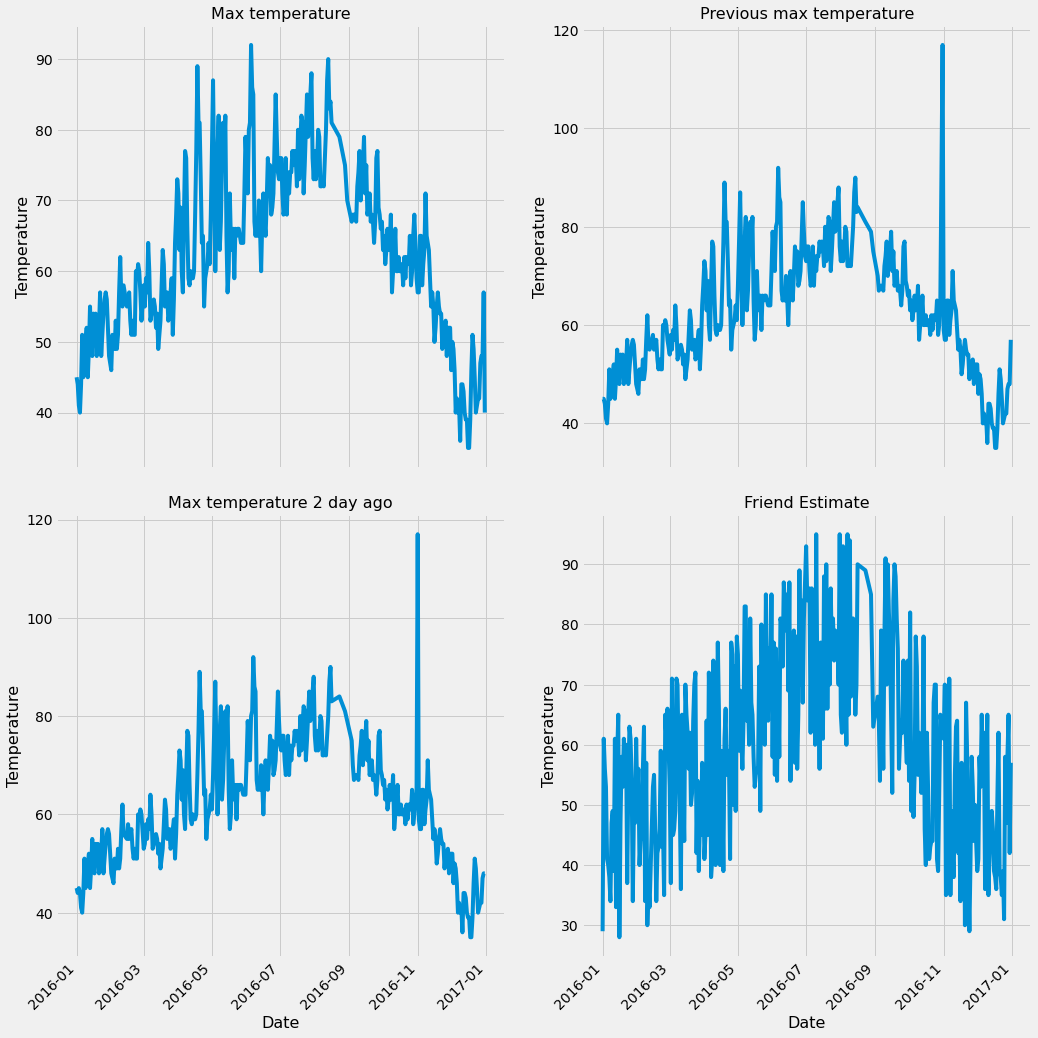

In [11]:
plt.style.use('fivethirtyeight')
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(15,15))
fig.autofmt_xdate(rotation=45)
#real temperature
ax1.plot(dates,data['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('Temperature',fontsize=16)
ax1.set_title('Max temperature',fontsize=16)


# temperature from 1 day ago
ax2.plot(dates,data['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature',fontsize=16)
ax2.set_title('Previous max temperature',fontsize=16)


# temperature from 2 day ago
ax3.plot(dates,data['temp_2'])
ax3.set_xlabel('Date',fontsize=16)
ax3.set_ylabel('Temperature',fontsize=16)
ax3.set_title('Max temperature 2 day ago',fontsize=16)


#temperature predict fro friend
ax4.plot(dates,data['friend'])
ax4.set_xlabel('Date',fontsize=16)
ax4.set_ylabel('Temperature',fontsize=16)
ax4.set_title('Friend Estimate',fontsize=16)

plt.tight_layout(pad=2)

# 2) Data Preparation 

## 2.1 Convert into one-hot coding 
In the raw data, the 'week' column is in string format,so we need to convert to int

In [12]:
data=pd.get_dummies(data)

In [13]:
labels=np.array(data['actual'])
data=data.drop('actual',axis=1)

In [14]:
feature_list=list(data.columns)
features=np.array(data)

# 2.2 Split data into training set and test set
<font size="3">I'm setting random state=42 which means the result will be the same time when I run the 
split for reproducible results</font>

In [15]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels=train_test_split(features,labels,test_size=0.25,random_state=42)

# 3 Train model

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000,random_state=42)# n_estimatos: number tree in ensemble
rf.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [17]:
predictions=rf.predict(test_features)
error=abs(predictions-test_labels)
print("Mean Absolute Error",np.mean(error))

Mean Absolute Error 3.8731954022988506


# Determines Performance Metrics
- Mean Absolute Percentage Error(MAPE)

In [18]:
mape=error/test_labels
print("Accuracy:",1-np.mean(mape))

Accuracy: 0.939325320799977


# 3.1 Visualize a single decision tree

In [19]:
from sklearn.tree import export_graphviz
import pydot

# pull one treen from the forest
tree=rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree,out_file='tree.dot',feature_names=feature_list,rounded=True,precision=1)

# Use the dot file to create graph
(graph,)=pydot.graph_from_dot_file('tree.dot')

#write graph to a png file
graph.write_png('tree.png')

In [20]:
print('Deepth the Decision Tree is',tree.tree_.max_depth)

Deepth the Decision Tree is 13


# Limit the decision tree with 2 level

In [21]:
rf_small=RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)
rf_small.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [22]:
# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

# 3.2 Variable Importances

In [28]:
importances=list(rf.feature_importances_)
features_importances=[(feature,round(importance,4)) for feature,importance in zip(feature_list,importances)]

In [38]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: temp_1               Importance: 0.6556
Variable: average              Importance: 0.1503
Variable: forecast_noaa        Importance: 0.0454
Variable: forecast_acc         Importance: 0.0349
Variable: forecast_under       Importance: 0.0232
Variable: day                  Importance: 0.0211
Variable: temp_2               Importance: 0.021
Variable: friend               Importance: 0.0207
Variable: month                Importance: 0.0103
Variable: week_Sat             Importance: 0.0036
Variable: week_Fri             Importance: 0.0035
Variable: week_Mon             Importance: 0.0026
Variable: week_Sun             Importance: 0.0023
Variable: week_Tues            Importance: 0.0023
Variable: week_Wed             Importance: 0.002
Variable: week_Thurs           Importance: 0.0013
Variable: year                 Importance: 0.0


# Model with 2 importance variable

In [40]:
rf_important=RandomForestRegressor(n_estimators=1000,random_state=42)
importance_index=[feature_list.index('temp_1'),feature_list.index('average')]
train_important=train_features[:,importance_index]
test_important=test_features[:,importance_index]

In [41]:
rf_important.fit(train_important,train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [42]:
prediction_important=rf_important.predict(test_important)
error_important=abs(prediction_important-test_labels)
print("Mean Absolute Error:",np.mean(error_important))

Mean Absolute Error: 3.9241832968436423


Text(0.5, 1.0, 'variable importances')

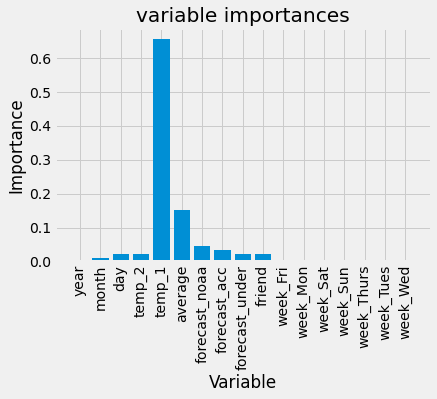

In [51]:
x_values=list(range(len(importances)))
plt.bar(x_values,importances,orientation='vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("variable importances")

In [55]:
true_data=pd.DataFrame(data={'date':dates,'actual':labels})

Text(0.5, 1.0, 'Acutual Max Temperature and Variables')

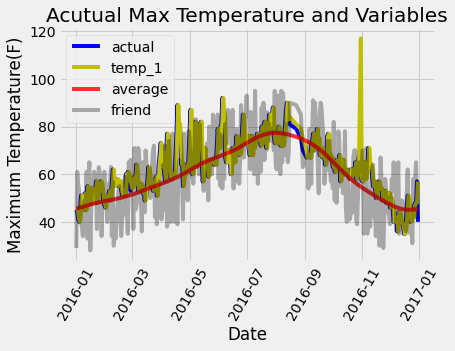

In [61]:
true_data['temp_1']=features[:,feature_list.index('temp_1')]
true_data['friend']=features[:,feature_list.index('friend')]
true_data['average']=features[:,feature_list.index('average')]

plt.plot(true_data['date'],true_data['actual'],'b-',label='actual',alpha=1.0)
plt.plot(true_data['date'],true_data['temp_1'],'y-',label='temp_1',alpha=1.0)
plt.plot(true_data['date'],true_data['average'],'r-',label='average',alpha=0.8)
plt.plot(true_data['date'],true_data['friend'],'k-',label='friend',alpha=0.3)
plt.legend()
plt.xticks(rotation='60')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature(F)')
plt.title('Acutual Max Temperature and Variables')